In [1067]:
import torch
import numpy as np
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from mpl_toolkits import mplot3d
from pathlib import Path
import string
from argparse import Namespace
import collections

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)

cmap=plt.cm.Spectral_r

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [2]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
for i,run in enumerate(runs[4:]):
    args = run['args']
    state_dict_old = torch.load(args.output_dir/'checkpoint.pth')['model']
    state_dict = collections.OrderedDict()
    for k in state_dict_old:
        state_dict[k.replace("alpha","gating_param")] = state_dict_old[k]
    state_dict_old['model']=state_dict
    torch.save(state_dict_old,args.output_dir/'checkpoint.pth')

In [1075]:
#1611224878 locality
#1611413693 datasize
#1611436788 model size CIFAR100

# 1611306605 model size Imagenet
# 1611509565 model size CIFAR100
# 1611525499 datasize

# 1611792683 model size Imagenet lr

runs = []
logs = []
indices = [-1]
numbers = [1611306605, 1611525499]

#for ind in indices:
for num in numbers:

    base = '/checkpoint/sdascoli/deit/'
    paths = sorted(glob.glob(base+'*'), key=(lambda x : x.split('/')[-1]))
    paths=[p for p in paths if os.path.isdir(p)]
    print(paths)
    last = paths[ind]
    path = last
    path = base+str(num)
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        print(dirname)
        try : 
            run = {}
            args = torch.load(dirname+'/args.pyT', map_location=torch.device('cpu'))
            run['args'] = args
            f = open(dirname+'/log.txt', "r")
            log = [eval(line) for line in f.readlines()]
            run['logs']=log
            runs.append(run)
        except: 
            print('failed {}'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
print(runs[0]['args'].data_set)
latest = min([len(run['logs']) for run in runs])-1
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    params[k] = sorted(list(set(params[k])))

['/checkpoint/sdascoli/deit/1611188311', '/checkpoint/sdascoli/deit/1611224878', '/checkpoint/sdascoli/deit/1611246814', '/checkpoint/sdascoli/deit/1611306605', '/checkpoint/sdascoli/deit/1611413693', '/checkpoint/sdascoli/deit/1611436788', '/checkpoint/sdascoli/deit/1611506917', '/checkpoint/sdascoli/deit/1611509565', '/checkpoint/sdascoli/deit/1611525499', '/checkpoint/sdascoli/deit/1611791721', '/checkpoint/sdascoli/deit/1611792552', '/checkpoint/sdascoli/deit/1611792683']
/checkpoint/sdascoli/deit/1611306605/
6 runs found
/checkpoint/sdascoli/deit/1611306605/layer_0_model_deit_tiny_patch16_224
/checkpoint/sdascoli/deit/1611306605/layer_0_model_deit_small_patch16_224
/checkpoint/sdascoli/deit/1611306605/layer_0_model_deit_base_patch16_224
/checkpoint/sdascoli/deit/1611306605/layer_10_model_deit_tiny_patch16_224
/checkpoint/sdascoli/deit/1611306605/layer_10_model_deit_small_patch16_224
/checkpoint/sdascoli/deit/1611306605/layer_10_model_deit_base_patch16_224
0 fails
['/checkpoint/sda

# Varying number of local layers

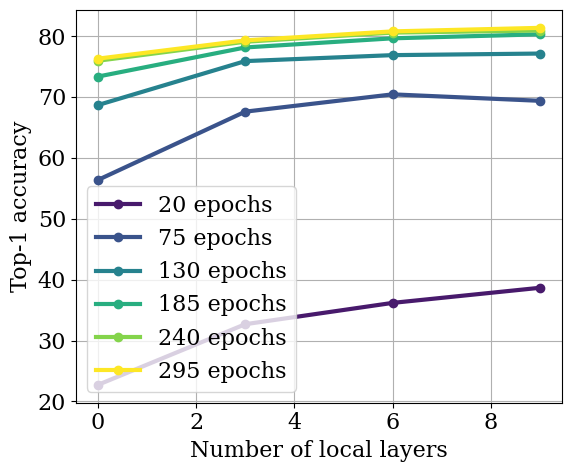

In [325]:
topk=1
cons = {'locality_strength':1,
       }
selected_runs, _ = select_runs(runs, params, cons)

plt.figure(figsize=(6,5))
times = range(20,latest-1,(latest-20)//5-1)
x, y = [], defaultdict(list)
for run in selected_runs:
    x.append(run['args'].local_up_to_layer)
    for t in times:
        y[t].append(run['logs'][t]['test_acc{}'.format(topk)])
#plt.annotate('Baseline',(min(x)+.1,min(y)+.1), color='red')
    
for t in times:
    plt.plot(x,y[t], marker='o', label='{} epochs'.format(t), color=plt.cm.viridis(t/times[-1]))
plt.legend()
plt.xlabel('Number of local layers')
plt.ylabel('Top-{} accuracy'.format(topk,latest))
plt.tight_layout()
plt.savefig(savedir+'acc_vs_locality.pdf')
plt.show()

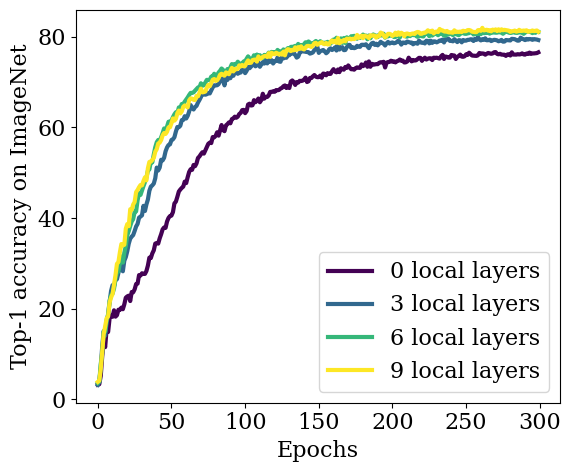

In [369]:
topk=1
cons = {'locality_strength':1,
       }
selected_runs, _ = select_runs(runs, params, cons)

plt.figure(figsize=(6,5))
for run in selected_runs:
    n_local = run['args'].local_up_to_layer
    latest = len(run['logs'])
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], 
             label='{} local layers'.format(n_local), color=plt.cm.viridis(n_local/max([run['args'].local_up_to_layer for run in selected_runs])))
    #plt.plot(range(latest), [run['test'][k]['loss'] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['train'][k]['loss'] for k in range(latest)], ls='--', color=cmap(n_local/12))
    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} accuracy on ImageNet'.format(topk))
plt.tight_layout()
plt.savefig(savedir+'acc_vs_locality_dynamics.pdf')
plt.show()

# Data size

2159
1407
864
300


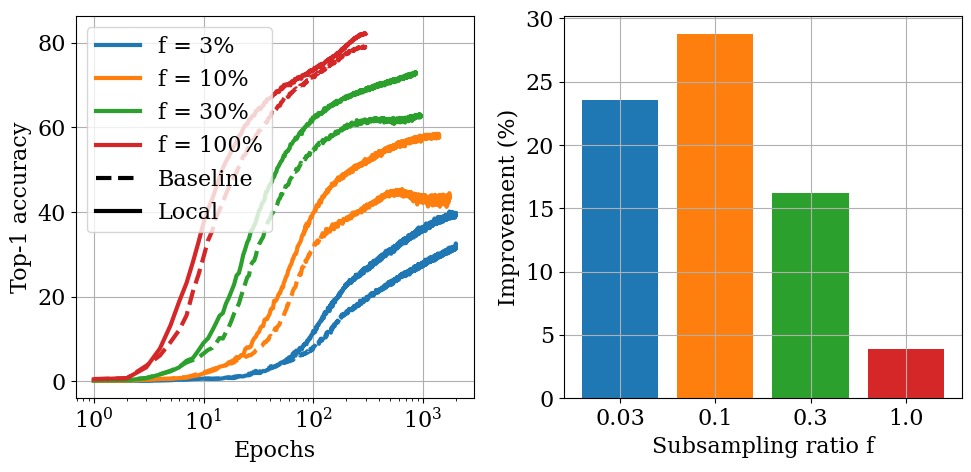

In [1076]:
topk=1

fig, axarr = plt.subplots(1,2,figsize=(10,5))
improvements=[]
perfs = {}
for i, sr in enumerate(params['sampling_ratio']):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sr, 
                                                 'model':'deit_small_patch16_224'})
    latest = min([len(run['logs']) for run in selected_runs])
    print(latest)
    for run in selected_runs:
        latest_run = len(run['logs'])
        local = bool(run['args'].local_up_to_layer)
        x = np.array(range(0,min(latest_run, max_epochs),1))
        axarr[0].plot(x+1, [run['logs'][k]['test_acc1'] for k in x], ls='-' if local else '--', 
                color = 'C%d'%i, 
                label=('f = {0:.0f}%'.format(sr*100)) if local else '',) 
        perfs[(sr,local)] = max([run['logs'][t]['test_acc1'] for t in range(latest)])
    try: 
        improvement = (perfs[(sr,True)]-perfs[(sr,False)])/perfs[(sr,False)]*100
        improvements.append(improvement)
        axarr[1].bar(i, improvement, color='C%d'%i)
    except: 
        continue

axarr[0].plot([],[],color='k',label='Baseline', ls='--')
axarr[0].plot([],[],color='k',label='Local')
axarr[0].legend()
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Top-{} accuracy'.format(topk))
axarr[0].set_xscale('log')
axarr[1].set_xticks(range(len(improvements)))
axarr[1].set_xticklabels(params['sampling_ratio'][:len(improvements)])
axarr[1].grid(True,zorder=0)
axarr[1].set_xlabel('Subsampling ratio f')
axarr[1].set_ylabel('Improvement (%)')
axarr[1].set_ylim(bottom=0)
plt.tight_layout()
plt.savefig(savedir+'data_size.pdf')
plt.show()

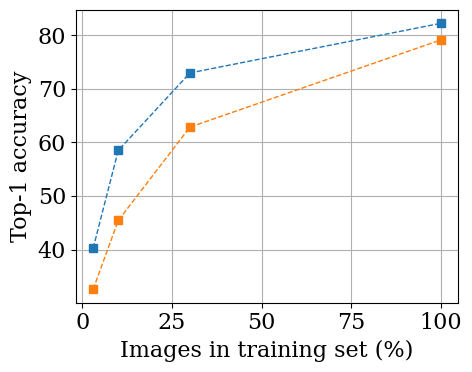

In [973]:
plt.figure(figsize=(5,4))
x = np.array(params['sampling_ratio'])
plt.plot(100*x,[perfs[(sr,True)] for sr in x ],ls='--',lw=1,marker='s',label='ConViT')
plt.plot(100*x,[perfs[(sr,False)] for sr in x],ls='--',lw=1,marker='s',label='DeiT')
#plt.scatter(1,77.9,marker='s',label='ViT', color='red')
plt.xlabel('Images in training set (%)')
plt.ylabel('Top-1 accuracy')
plt.tight_layout()
plt.savefig(savedir+'data_size_intro.pdf')
plt.show()

# Model size

deit_base_patch16_224 False 300 77.0840022290039
deit_base_patch16_224 True 259 82.12800239990234
deit_small_patch16_224 False 300 78.81000238525391
deit_small_patch16_224 True 300 82.1300024584961
deit_tiny_patch16_224 False 300 76.10800227539063
deit_tiny_patch16_224 True 299 76.70200224365234


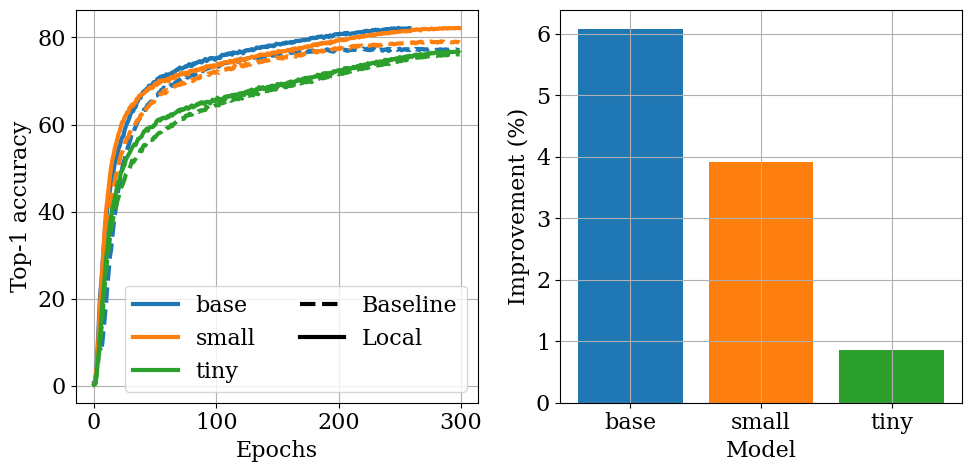

In [1077]:
topk=1
max_epochs = 2000

fig, axarr = plt.subplots(1,2,figsize=(10,5))

improvements = []
for i, model in enumerate(params['model']):
    selected_runs, _ = select_runs(runs, params, {'model':model, 'sampling_ratio':1})
    latest = min([len(run['logs']) for run in selected_runs])
    perfs = {}
    for run in selected_runs:
        latest_run = len(run['logs'])
        local = bool(run['args'].local_up_to_layer)
        x = range(0,min(latest_run, max_epochs),1)
        axarr[0].plot(x, [run['logs'][t]['test_acc%d'%topk] for t in x], ls='-' if local else '--', label=(model.split('_')[1]) if local else '', color = 'C%d'%i)
        #axarr[0].plot(x, [run['logs'][t]['train_lr'] for t in x], ls='-' if local else '--', label=(model.split('_')[1]) if local else '', color = 'C%d'%i)
        perfs[local] = max([run['logs'][t]['test_acc1'] for t in range(latest)])
        print(model,local,latest_run,run['logs'][latest-1]['test_acc%d'%topk])
        
    improvement = (perfs[True]-perfs[False])/perfs[False]*100
    improvements.append(improvement)
    axarr[1].bar(i, improvement, color='C%d'%i)


axarr[0].plot([],[],color='k',label='Baseline', ls='--')
axarr[0].plot([],[],color='k',label='Local')
axarr[0].legend(ncol=2)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Top-{} accuracy'.format(topk))
axarr[1].set_xticks(range(len(improvements)))
axarr[1].set_xticklabels([label.split('_')[1] for label in params['model']])
axarr[1].set_xlabel('Model')
axarr[1].set_ylabel('Improvement (%)')
axarr[1].set_ylim(bottom=0)
plt.tight_layout()
#plt.savefig(savedir+'model_size_{}.pdf'.format(params['data_set'][0]))
plt.show()

# Grid search

In [ ]:
latest = min([len(run['logs']) for run in runs])
topk=1
#key1 = 'local_up_to_layer'
#key2 = 'locality_strength'

plt.figure()
grid = np.zeros((len(params[key1]),len(params[key2])))
for run in runs:
    args = run['args']
    i,j = find(getattr(args,key1), params[key1]), find(getattr(args,key2), params[key2])
    grid[i,j] = run['logs'][latest-1]['test_acc%d'%topk]
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], label='{} {}'.format(getattr(args,key1), getattr(args, key2)))    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

print(np.max(grid))

plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.gca().set_xticks(range(len(params[key2])))
plt.gca().set_yticks(range(len(params[key1])))
plt.gca().set_xticklabels(params[key2])
plt.gca().set_yticklabels(params[key1])
plt.xlabel(r'$\mathrm{Number\ of\ local\ layers}$')
plt.ylabel(r'$\mathrm{Locality\ strength}\ \alpha$')
plt.colorbar()
plt.tight_layout()
plt.grid(False)
#plt.savefig(savedir+'strength.pdf')
plt.show()

# Attention maps

In [1070]:
from main import create_model, build_dataset
%load_ext autoreload
%autoreload 2

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='red', lw=3, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def plot_attention(model,x,layers=[0], save=False, init=False, title=None):
    
    x = model.patch_embed(x)
    
    num_patches = model.num_patches
    img_size = int(num_patches**.5)
    num_heads = model.blocks[0].attn.num_heads
    embed_dim = model.embed_dim

    num_layers = len(layers)
    fig, axarr = plt.subplots(num_layers, num_heads, figsize=(2*num_heads,2*num_layers), constrained_layout=True)
    if num_layers==1:
        axarr = [axarr]
    dists, alphas = {},{}
    for i, l in enumerate(layers):
        dists[l], attn_map = model.blocks[l].attn.get_attention_map(x, return_map=True)
        num_heads = len(attn_map)
        for head in range(num_heads):
            head_map = attn_map[head,num_patches//2+img_size//2].detach().cpu().resize(img_size,img_size)
            axarr[i][head].matshow(np.log10(head_map), cmap=plt.cm.viridis)
            if l < model.local_up_to_layer:
                try:
                    alpha = model.blocks[l].attn.alpha.squeeze()[head].item()
                except:
                    alpha = model.blocks[l].attn.alpha.squeeze()[head].item()
                if not init: axarr[i][head].annotate(r'$\sigma(\lambda)={0:.2f}$'.format(sigmoid(alpha)), xy=(.3,1.5), fontsize=20, color=plt.cm.Reds(sigmoid(alpha)))
            #print(head_map)
        for ax in axarr[i]:
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            highlight_cell(img_size//2, img_size//2,ax)
                
    cols = [r'Head {}'.format(col+1) for col in range(num_heads)]
    rows = ['Layer {}'.format(row+1) for row in layers]
    for ax, col in zip(axarr[0], cols):
        ax.set_title(col, fontsize=15, pad=10)
    if not init:
        for ax, row in zip(axarr[:,0], rows):
            ax.set_ylabel(row, fontsize=15, labelpad=10)
    
    #plt.subplots_adjust(wspace=.1, hspace=.1)
    #plt.tight_layout(h_pad=-1, w_pad=-1)
    if save:
        if init:
            plt.savefig(savedir+title)
        else:
            plt.savefig(savedir+'attention_map_final_{}_{}_{}.pdf'.format(('local' if model.local_up_to_layer else 'nonlocal'),args.model.split('_')[1],args.data_set))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


/checkpoint/sdascoli/deit/1611306605/layer_10_model_deit_tiny_patch16_224/checkpoint.pth


/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


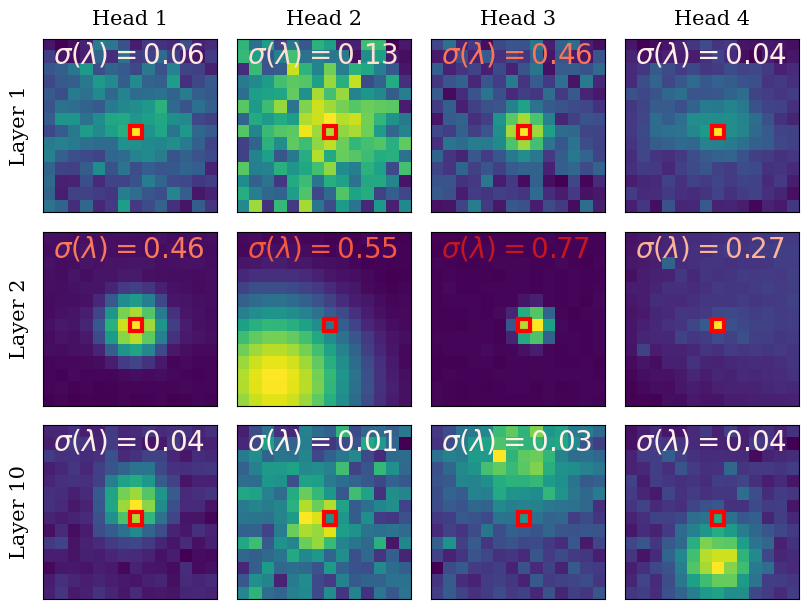

In [1074]:
cons = {'model': 'deit_tiny_patch16_224',
        'local_up_to_layer' : 10,
        'locality_strength':1
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
args = run['args']
model = create_model(args.model, num_classes=args.nb_classes,
                    local_up_to_layer=args.local_up_to_layer, 
                    locality_dim=args.locality_dim)
model.to('cuda')

args = run['args']
args.sampling_ratio = 0.001
dataset, _ = build_dataset(is_train=False, args=args)
x = torch.stack([dataset[i][0] for i in range(200)])
x = x.cuda()


for path in glob.glob(str(args.output_dir/'checkpoint*')):
    print(path)
    state_dict = torch.load(path)["model"]
    model.load_state_dict(state_dict)

    plot_attention(model, x, layers=[0,1,9], save=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/tensor.py:454: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


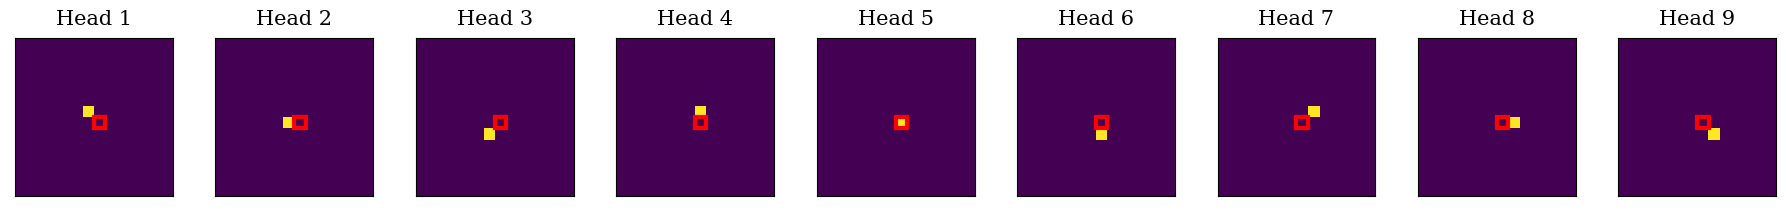

In [1004]:
strength=10
local=10
from main import create_model, build_dataset
model = create_model('deit_small_patch16_224', local_up_to_layer=local, locality_strength=strength, locality_dim=10)
model.to('cuda')
for l in range(local):
    mixing_parameter = model.blocks[l].attn.mixing_parameter.data.fill_(0)
    del(model.blocks[l].attn.mixing_parameter)
    model.blocks[l].attn.mixing_parameter = mixing_parameter

if local:
    title='attention_map_init_local_strength_{}.pdf'.format(strength)
else:
    title='attention_map_init_nonlocal.pdf'

plot_attention(model, x, layers=[0], init=True, save=True, title=title)

# Nonlocality

In [ ]:
topk=1

cons = {'model': 'deit_base_patch16_224',
        'local_up_to_layer' : 10,
        'locality_strength':1,
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
latest = len(run['logs'])
args = run['args']

plt.figure(figsize=(8,5))
grid = np.zeros((len(params[key1]),len(params[key2])))
for l in range(12):
    args = run['args']
    plt.plot(range(latest), [run['logs'][k]['attn_distance_%d'%l] for k in range(latest)], color=cmap(l/12), label='Layer %d'%(l+1))  

plt.legend(bbox_to_anchor=(1.1,1))
plt.xlabel('Epochs')
plt.ylabel('Non-locality'.format(topk,latest))
plt.tight_layout()
plt.savefig(savedir+'nonlocality_{}_{}_{}.pdf'.format('local' if args.local_up_to_layer else 'nonlocal', args.model.split('_')[1],args.data_set))
plt.show()

# Locality parameters

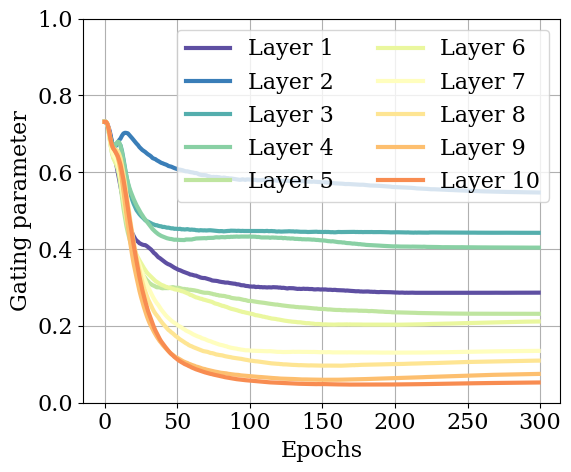

In [1039]:
topk=1

cons = {'model': 'deit_small_patch16_224',
        'local_up_to_layer' : 10,
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
latest = len(run['logs'])
args = run['args']

plt.figure(figsize=(6,5))
grid = np.zeros((len(params[key1]),len(params[key2])))
for l in range(args.local_up_to_layer):
    plt.plot(range(latest), [sigmoid(run['logs'][k]['locality_param_%d'%l]) for k in range(latest)], color=cmap(l/12), label='Layer %d'%(l+1))  

plt.legend(ncol=2)
plt.xlabel('Epochs')
plt.ylabel('Gating parameter'.format(topk,latest))
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(savedir+'gating_parameter_{}_{}.pdf'.format(args.model.split('_')[1],args.data_set))
plt.show()

No handles with labels found to put in legend.


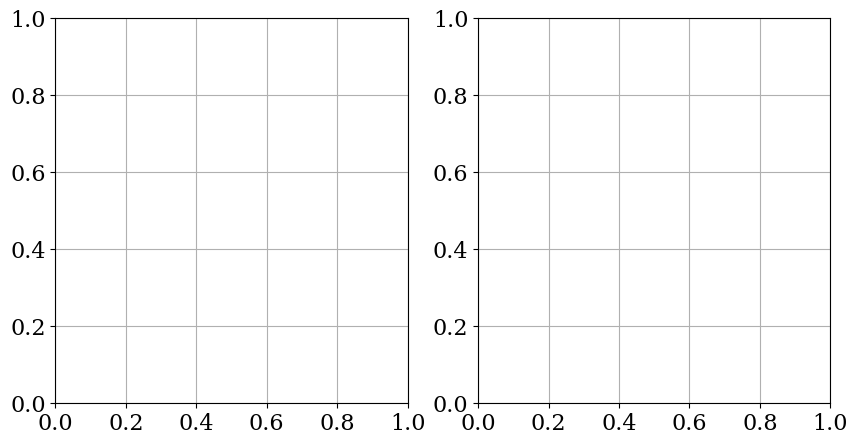

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

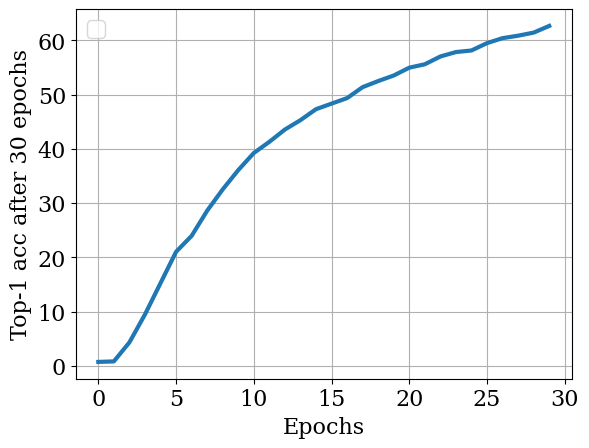

In [704]:
latest = min([len(run['logs']) for run in runs])
topk=1

plt.figure()
for run in runs:
    args = run['args']
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)])    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Hugo

In [975]:
# 35343650 distillation nonlocal
# 35343651 distillation local

runs = []
logs = []
numbers = [35343650,35343651]

for num in numbers:

    base = "/checkpoint/htouvron/Classification_transformers/"
    path = base + str(num) + '/'
    print(path)
    run = {}
    false=False
    true=True
    null=None
    with open(path+"commandline_args.txt", "r") as file:
        contents = file.read()
        args = eval(contents)
    args = Namespace(**args)
    args.output_dir=path
    run['args']=args
    runs.append(run)
    
print(runs[0]['args'].data_set)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    params[k] = sorted(list(set(params[k])))
    
x = model.patch_embed(x)

/checkpoint/htouvron/Classification_transformers/35343650/
/checkpoint/htouvron/Classification_transformers/35343651/
IMNET


0
20
40
60
80
100
120
0
20
40
60
80
100
120


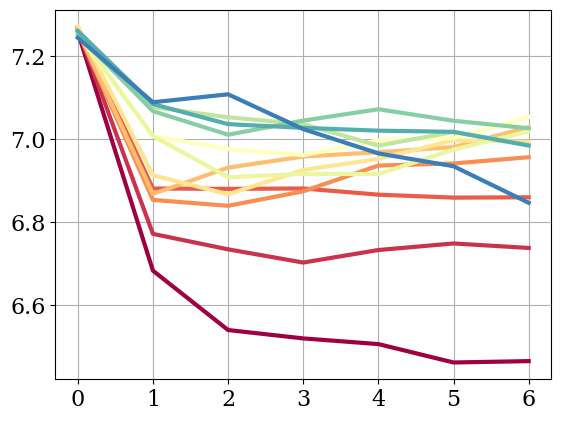

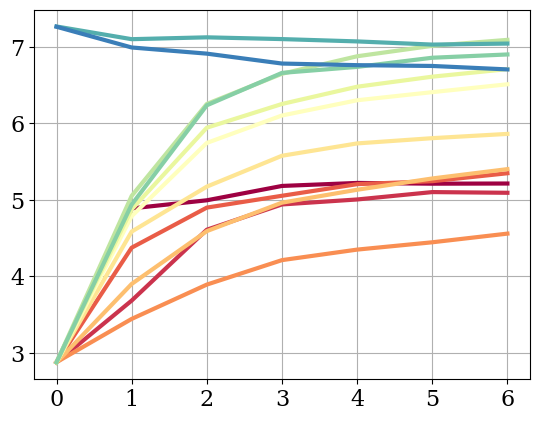

In [993]:
for i, local_up_to in enumerate([0, 10]):
    plt.figure()
    model = model = create_model('deit_small_patch16_224', local_up_to_layer=local_up_to, locality_dim=10)
    gatings = defaultdict(list)
    nonlocalities = defaultdict(list)
    for t in range(0,140,20):
        print(t)
        state_dict_old = torch.load(runs[i]['args'].output_dir+'checkpoint_{}.pth'.format(t))['model']
        state_dict = collections.OrderedDict()
        for k in state_dict_old:
            state_dict[k.lstrip('module.').replace("alpha","mixing_parameter")] = state_dict_old[k]
        model.load_state_dict(state_dict)
        model = model.to('cuda')

        for l in range(12):
            if l<local_up_to: 
                gating = sigmoid(model.blocks[l].attn.mixing_parameter.mean().item())
                gatings[l].append(gating)
            nonlocality = model.blocks[l].attn.get_attention_map(x)
            nonlocalities[l].append(nonlocality)
    for l in range(12):
        plt.plot(nonlocalities[l],color=plt.cm.Spectral(l/12))
plt.show()


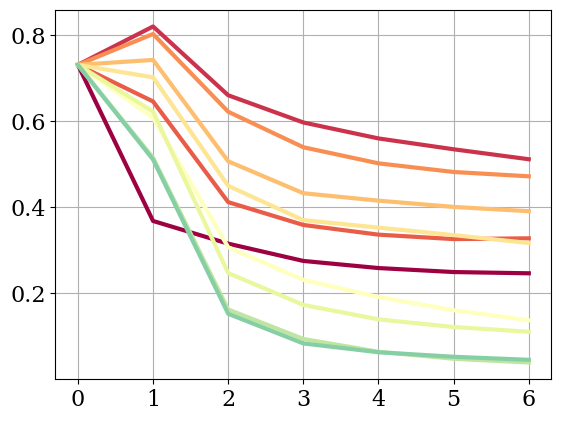

In [996]:
plt.figure()
for l in range(12):
    plt.plot(gatings[l],color=plt.cm.Spectral(l/12))
plt.show()